In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import load_dataset

In [8]:
CATEGORY_MAPPING = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
np.random.seed(42)

def load_and_preprocess_data():
    dataset_name = "fancyzhx/ag_news"
    dataset = load_dataset(dataset_name)
    
    train_data = dataset["train"].to_pandas()
    test_data = dataset["test"].to_pandas()
    
    train_data['Category'] = train_data['label'].map(CATEGORY_MAPPING)
    test_data['Category'] = test_data['label'].map(CATEGORY_MAPPING)
    
    return train_data, test_data

In [9]:
class MLPTextClassifier:
    def __init__(self, hidden_layer_sizes=(64, 32), alpha=0.001, max_iter=100):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.alpha = alpha
        self.max_iter = max_iter
        self.vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_features=1000)
        self.label_encoder = LabelEncoder()
        self.model = None
    
    def fit(self, X_train, y_train):
        X_train_tfidf = self.vectorizer.fit_transform(X_train)
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        
        self.model = MLPClassifier(hidden_layer_sizes=self.hidden_layer_sizes, activation='relu', solver='adam',
                                   alpha=self.alpha, random_state=42, batch_size=32, learning_rate_init=0.01,
                                   max_iter=self.max_iter)
        self.model.fit(X_train_tfidf, y_train_encoded)
    
    def predict(self, X_test):
        X_test_tfidf = self.vectorizer.transform(X_test)
        predictions = self.model.predict(X_test_tfidf)
        return self.label_encoder.inverse_transform(predictions)

In [10]:
def build_pipeline():
    return MLPClassifier()

In [11]:
# Confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.8762

Classification Report:
              precision    recall  f1-score   support

    Business       0.84      0.85      0.84      1900
    Sci/Tech       0.86      0.83      0.84      1900
      Sports       0.91      0.95      0.93      1900
       World       0.89      0.88      0.89      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



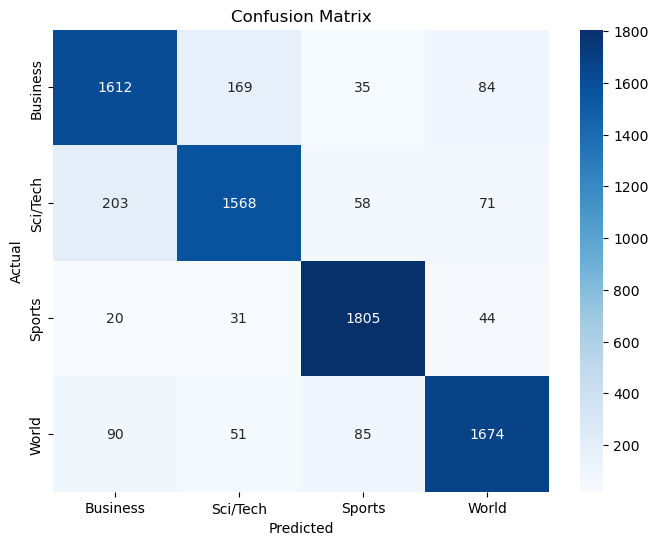

=== Predictions ===
Text: Global economic markets show strong recovery trends
Predicted Label: Business

Text: Champions League final sees record-breaking attendance
Predicted Label: Sports



In [12]:
train_df, test_df = load_and_preprocess_data()
X_train, y_train = train_df['text'], train_df['Category']
X_test, y_test = test_df['text'], test_df['Category']

# Train MLP classifier
mlp_classifier = MLPTextClassifier(hidden_layer_sizes=(64, 32), alpha=0.001, max_iter=100)
mlp_classifier.fit(X_train, y_train)

y_pred = mlp_classifier.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=train_df['Category'].unique())

# Predict new samples
new_samples = [
    "Global economic markets show strong recovery trends",
    "Champions League final sees record-breaking attendance"
]
y_new_pred = mlp_classifier.predict(new_samples)

print("=== Predictions ===")
for text, pred in zip(new_samples, y_new_pred):
    print(f"Text: {text}\nPredicted Label: {pred}\n")